# Credit Analysis: A Classification Problem
---

## 1. Introduction

Credit analysis is a critical service in financial ecosystems, helping to assess and mitigate the risk of granting credit to potential borrowers. This project utilizes data from 1,319 credit card applications, detailed with 12 variables including credit acceptance, financial behavior reports, income, and expenditure ratios. The dataset is derived from the exemplary work found in G.W. Greene's "Econometric Analysis, 5th edition."

The main objectives of this study are:
1. To understand the current credit analysis process and identify potential areas for improvement.
2. To develop a classification model that delivers more accurate and effective outcomes than existing methodologies.

This project aims not just to predict creditworthiness but also to enhance the decision-making process in financial lending practices. For additional data insights, please refer to the detailed dataset documentation available at [here](https://vincentarelbundock.github.io/Rdatasets/doc/AER/CreditCard.html).

---

## 2. Data Cleaning and Exploration

To start, I'll import just basic libraries used for data manipulation, visualization, and statistical tests, aiming to accomplish my first objective.

In [1]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Then, I'll import the data and return a sample of it, along with information about datatypes, null values, and descriptive measures for numeric columns:

In [2]:
# Storing data and showing basic information
path = os.path.abspath('../data/CreditCard.csv')
df = pd.read_csv(path)
df.sample(10), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rownames     1319 non-null   int64  
 1   card         1319 non-null   object 
 2   reports      1319 non-null   int64  
 3   age          1319 non-null   float64
 4   income       1319 non-null   float64
 5   share        1319 non-null   float64
 6   expenditure  1319 non-null   float64
 7   owner        1319 non-null   object 
 8   selfemp      1319 non-null   object 
 9   dependents   1319 non-null   int64  
 10  months       1319 non-null   int64  
 11  majorcards   1319 non-null   int64  
 12  active       1319 non-null   int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 134.1+ KB


(      rownames card  reports       age  income     share  expenditure owner  \
 1317      1318  yes        0  32.83333  3.7000  0.008999     26.99667    no   
 988        989   no        5  40.08333  4.4000  0.000273      0.00000   yes   
 295        296  yes        1  53.58333  9.9999  0.099870    832.24330   yes   
 830        831  yes        0  23.83333  2.3500  0.069766    136.04080    no   
 1273      1274  yes        0  37.33333  7.0000  0.030232    176.27170   yes   
 993        994  yes        0  25.00000  2.4000  0.031587     62.50833    no   
 3            4  yes        0  30.50000  2.5400  0.065214    137.86920    no   
 837        838  yes        1  38.00000  3.2700  0.238693    650.43750    no   
 1184      1185   no        0  35.83333  4.5000  0.000267      0.00000   yes   
 287        288  yes        0  21.25000  1.7500  0.193239    281.80670    no   
 
      selfemp  dependents  months  majorcards  active  
 1317     yes           0      60           1       7  
 988  

Some things to mention:
- There are **no null values in the data (yay!)**
- Datatypes look correct, but **binary columns can become numerical**
- **Rownames should be dropped**
- From the columns that were described, **all but majorcards seem to have outliers:**
    - Outliers for income and dependents are reasonable, but I'd like to give a further look to when income is close to 0
    - Outliers for when age is 0 or close don't make sense.
        - Depending on their %, I'll either drop them or replace them for a minimal age, like 18.
    - Outliers for share or expenditure indicate people who are spending more than they earn, which possibly shows a misclassification from the current model.
    - Outliers for reports or active seem reasonable as well, but I'd like to guve a further look

Now, I'll describe the columns that are still objects

In [3]:
# Selecting object coluns, mapping them to 1/0, and describing them
df.select_dtypes('object').apply(lambda col: col.replace({'yes': 1, 'no': 0})).describe()

,card,owner,selfemp
count,1319.000000,1319.000000,1319.000000
mean,0.775588,0.440485,0.068992
std,0.417353,0.496634,0.253536
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


Other things to mention:
- **Card is unbalanced** and probably will need balancing when training the model.
- Owner and selfemp are ok

Now I'll quickly drop rownames and convert categorical columns to numerical.   

In [4]:
# dropping rownames
df.drop('rownames', axis=1, inplace=True)

In [5]:
df['card'] = (df['card']=='yes').astype(int)
df['owner'] = (df['owner']=='yes').astype(int)
df['selfemp'] = (df['selfemp']=='yes').astype(int)

# Showing if all transformations were performed correctly
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,1,0,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,0,0,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,1,0,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,0,0,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,1,0,2,64,1,5


With all being done correctly, I'd like to **visualize the data distribution for each column** before I deal with outliers and age.

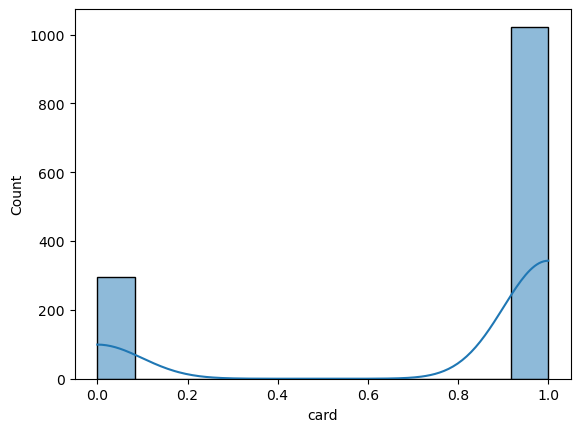

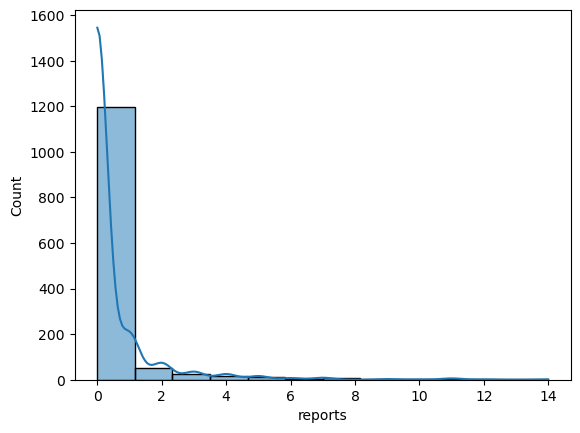

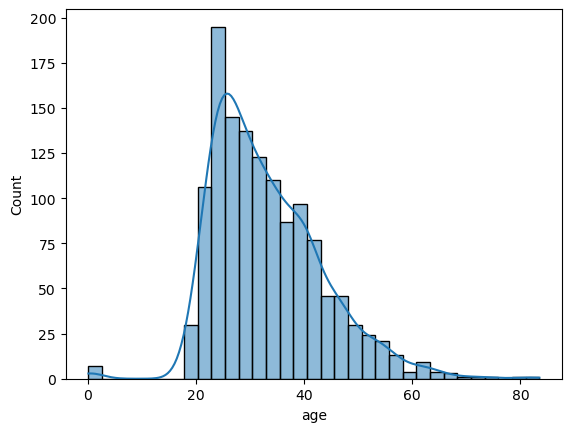

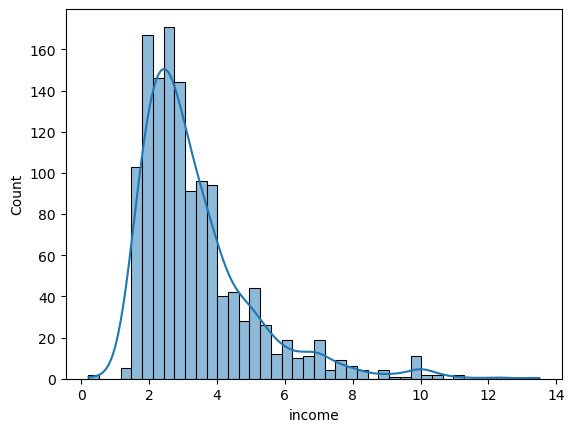

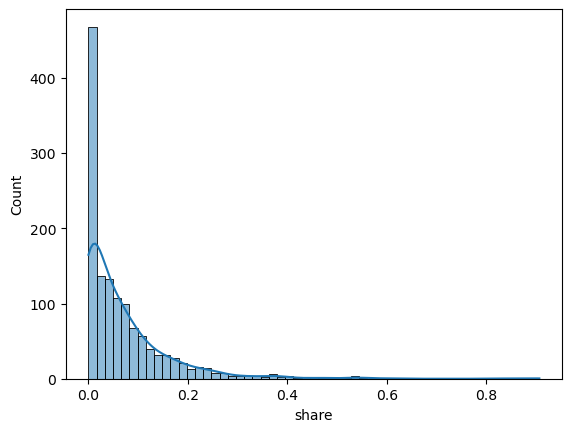

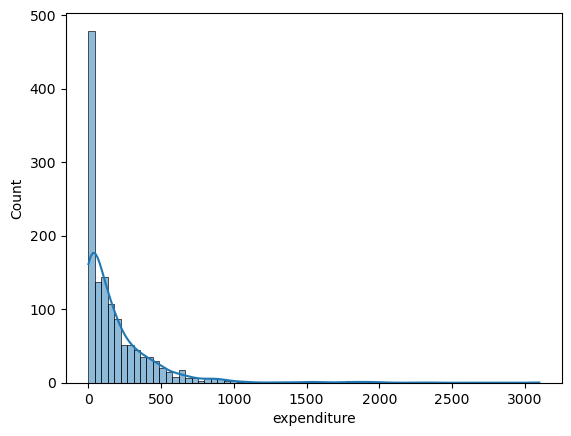

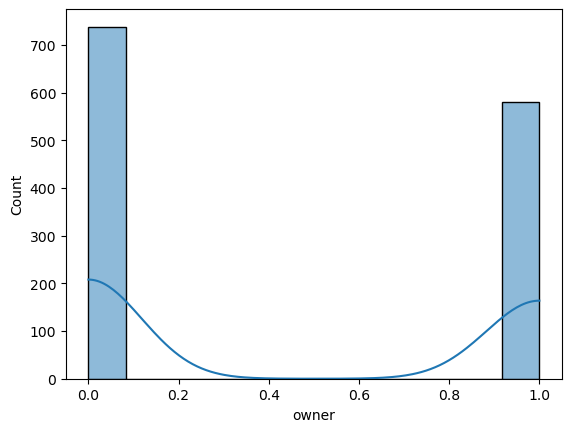

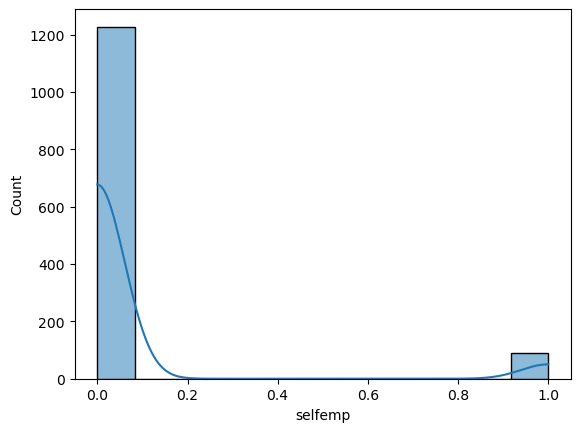

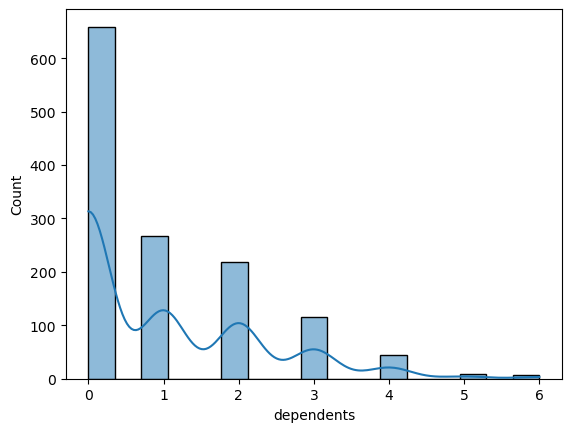

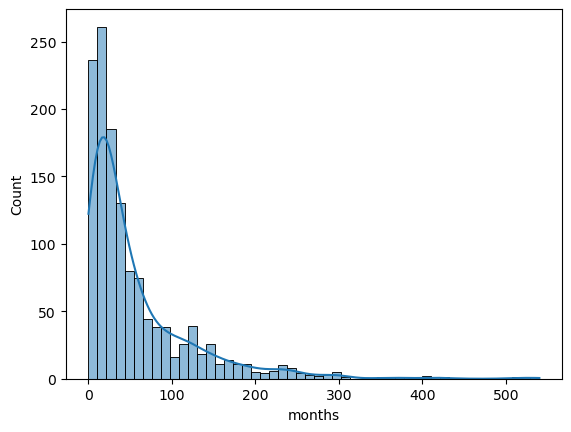

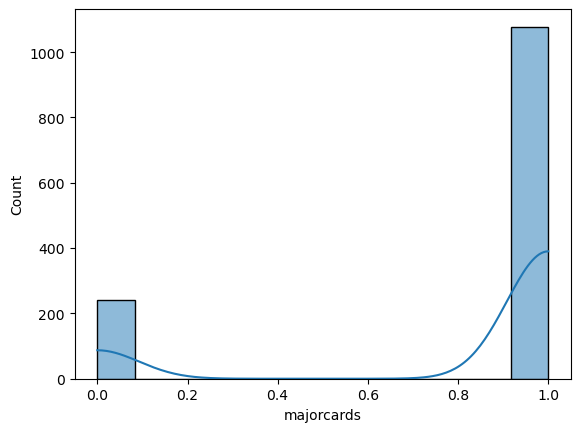

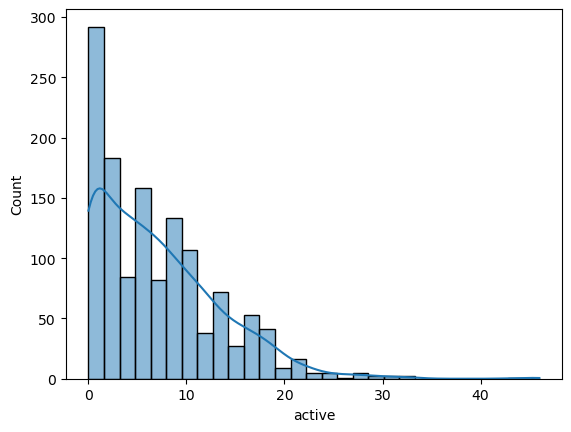

In [6]:
for col in df.columns:
    sns.histplot(df[col], kde=True)
    plt.show()

Most distributions are **skewed to the right.** I might come back here to see if this will impact my predictions   
Also, again, age and income also have some data points to the left of the mode. I'll analyse them now.

In [7]:
# Creating a dict with column name and possible thresholds observed in the histogram
low_outliers = {'age': 18, 'income': 1.5}
for col, threshold in low_outliers.items():
    print(df.loc[df[col] < threshold, :])
    print('----------')

      card  reports       age  income     share  expenditure  owner  selfemp  \
78       1        0  0.500000    3.05  0.101724    258.54920      0        0   
323      1        0  0.166667    3.24  0.184366    497.70580      1        0   
434      1        0  0.583333    2.50  0.083171    173.02330      0        0   
461      0        0  0.750000    3.00  0.000400      0.00000      0        0   
655      1        0  0.583333    4.00  0.072664    242.12830      1        0   
658      1        1  0.500000    3.70  0.010637     32.46416      0        0   
1194     1        0  0.750000    1.60  0.154191    205.25420      0        0   

      dependents  months  majorcards  active  
78             1      94           1       5  
323            3      25           1      16  
434            0     150           1       5  
461            0      18           0       2  
655            3      24           1       4  
658            0     186           0       5  
1194           0       1      

Rows with **low age**, in general, have income, card, dependents, own a house, etc. It indicates wrong inputation that can be fixed, rather than deleting the entire row. The strategy here will be replace by the median age from rows with the same number of dependents. 

Rows with **low income** are few (only 2 with income < 1). One has a card while the other doesn't. They also differ in share/expenditure, but are similar in regards to owning a house, not being self-employed, having the same number of dependents, and 1 majorcard. Since I couldn't come up with a strategy to input based on similar rows,I will replace it by 1.2, which is the next lowest value.

Finally, this brought to me another possible inconsistency:
   
**Rows with 0 spent BUT  share > 0.**   
   
I'd like to analyse those rows to understand especially the association between majorcards, share, income and expenditure.

In [8]:
# Fixing low ages
# Creates a dict of # dependents and median age
replacer = dict(df.groupby('dependents')['age'].median())

# Iterates over replacer, replacing low ages in the dataframe when the number of dependents matches
for dependent, age in replacer.items():
    df.loc[(df['age']<18) & (df['dependents']==dependent), 'age'] = age

In [9]:
# Fixing low incomes
df.loc[df['income'] < 1.2, 'income'] = 1.2

In [10]:
# Checking rows with 0 spent
df.loc[df['expenditure']==0].describe()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
count,317.000000,317.000000,317.000000,317.000000,317.000000,317.0,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000
mean,0.066246,1.485804,33.460305,3.053057,0.000478,0.0,0.309148,0.097792,1.034700,55.053628,0.747634,6.100946
std,0.249105,2.364817,10.147580,1.588800,0.000211,0.0,0.462873,0.297503,1.243487,71.029279,0.435057,6.886230
min,0.000000,0.000000,19.000000,1.200000,0.000109,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,25.583330,2.000000,0.000333,0.0,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
50%,0.000000,0.000000,31.666670,2.600000,0.000462,0.0,0.000000,0.000000,1.000000,36.000000,1.000000,4.000000
75%,0.000000,2.000000,38.333330,3.600000,0.000600,0.0,1.000000,0.000000,2.000000,62.000000,1.000000,9.000000
max,1.000000,14.000000,80.166660,11.000000,0.002449,0.0,1.000000,1.000000,6.000000,528.000000,1.000000,46.000000


Applicants with 0 spent:
- Mostly, don't have a card (which makes sense). Those who have may be new credit card holders.
- All of them have a share, even though it is small.
- Interestingly, there are some who also don't have any majorcards (which starts to be problematic).

In [11]:
# Checking % of applicants with 0 spent, no majorcards, no active acounts
probabibly_inconsistent = (df['expenditure'] == 0) & (df['majorcards']==0) & (df['active']==0) & (df['card']==0)
print(f'% of problematic applications: {df.loc[probabibly_inconsistent].shape[0] / df.shape[0] * 100 :.2f}%')
df.loc[probabibly_inconsistent]

% of problematic applications: 1.36%


,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
50,0,0,49.75000,3.6000,0.000333,0.0,0,0,2,12,0,0
58,0,0,44.66667,1.8000,0.000667,0.0,0,0,2,33,0,0
65,0,0,26.16667,2.5000,0.000480,0.0,0,1,0,18,0,0
213,0,0,22.83333,3.1475,0.000381,0.0,0,0,2,19,0,0
238,0,0,28.00000,1.5000,0.000800,0.0,0,0,1,5,0,0
319,0,0,23.91667,1.2000,0.001000,0.0,0,0,0,15,0,0
339,0,0,31.66667,3.0000,0.000400,0.0,0,0,0,12,0,0
350,0,0,32.08333,2.1600,0.000556,0.0,0,0,0,42,0,0
454,0,0,35.91667,1.8500,0.000649,0.0,0,0,0,62,0,0
465,0,0,23.83333,2.2000,0.000545,0.0,0,0,0,31,0,0


In [12]:
# Checking if share is really equal to monthly expense / yearly income
assumed_share = (df['share'] == (12 * df['expenditure']) / (df['income'] * 10000)).sum() 
print(f'% of rows where share is really monthly expense divided by yearly income: {assumed_share/df.shape[0] * 100 :.2f}')

% of rows where share is really monthly expense divided by yearly income: 1.82


And what about the standard error?

In [13]:
df['yearly_expenditure'] = df['expenditure'] * 12 / 10000
df['expected_share'] = df['yearly_expenditure'] / df['income']
abs_avg_error = abs(df['expected_share'] - df['share']).mean()
print(f'On average, the absolute expected share is about {round(abs_avg_error,4)} different than the computed share')

On average, the absolute expected share is about 0.0004 different than the computed share


In [14]:
# Checking the mean to compare
print(f'This represents {abs_avg_error / df["share"].mean() * 100: .2f}% of the average computed share')

This represents  0.53% of the average computed share


Since the difference is less than 1%, on average, I will utilize the expected share from now on, because it is in accordance with the documentation.

Just before I move on to the bivariate analysis, I'll create a new column for the target.   
Basically, I will consider the **maximun ideal expected share** to be **1/12**, because anything greater than this represents a high risk of default.

In [15]:
def new_target(df: pd.DataFrame, max_ideal_share=1/12):
    """
    To be applied on a DataFrame.
    Returns 0 (Denied application), 1 (Accepted application with high risk to default), 2 (Accepted application with risk ok)
    """
    if df['card'] == 0:
        return 0
    elif df['expected_share'] > max_ideal_share:
        return 1
    else:
        return 2

df['target'] = df.apply(new_target, axis=1)

In [16]:
(df['target'].value_counts() / df.shape[0]) * 100

2    49.431387
1    28.127369
0    22.441243
Name: target, dtype: float64

Approximately 28% of all dataset is made of accepted applications with high risk to default!    
 
If they really defaulted, how much the business would lose?

In [17]:
defaulted = df['target'] == 1
loss = (
        (df.loc[defaulted]['share'] - 1/12)  # Amount of share exceeding the max ideal
        * df.loc[defaulted]['income'] # Times yearly income in 10,000 USD
).sum() * 10000 
print(f'The business would lose ${loss: ,.2f} USD!!!')

The business would lose $ 1,083,496.87 USD!!!


How much this represents from all the money the business makes with their clients?

In [18]:
revenue = df.loc[df['card']==1, 'income'].sum() * 10000 - loss
print(f'This represents {loss/revenue * 100: .2f}% of the yearly revenue')

This represents  3.17% of the yearly revenue


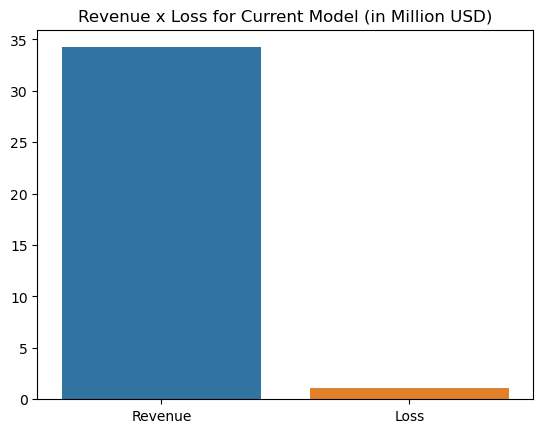

In [19]:
# Plotting the difference
values_current_model = np.array([revenue, loss])/1000000
sns.barplot(x=['Revenue', 'Loss'], y=values_current_model)
plt.title('Revenue x Loss for Current Model (in Million USD)')
plt.show()

With an understanding of the current situation, we can beging to think about how to deliver better results for this company.   
The basic ideal is to modeal a new solution that **maximizes revenue** and **minimizes loss**, when compared with the initial approach.

A initial step would be to **create a first model to estimate how much would a person spend if given a credit card.**   
Thus I would build a **Regressor** before a **Classifier.**
With an estimated expenditure, I could decide whether the application should be accepted or denied.

So far, the dataset presents us with 4 group of rows:

1. Card = 0 & Expenditure = 0
2. Card = 1 & Expenditure = 0 (probably applications just accepted)
3. Card = 1 & Expected Share <= Yearly Income/12 
4. Card = 1 & Expected Share > Yearly Income/12

I will train and test with the groups 3 and 4. Then I can make an educated guess for group 2.   
However, group 1 is different. They are applications denied for an unknown reason to me. My first ideal is to estimate their expenditure as I would normally do plus 1/12 of their yearly income.

To validate my initial assumptions/ideas, I'll proceed with the EDA and will compare **how the group declined is different/similar from the group that was accepted**

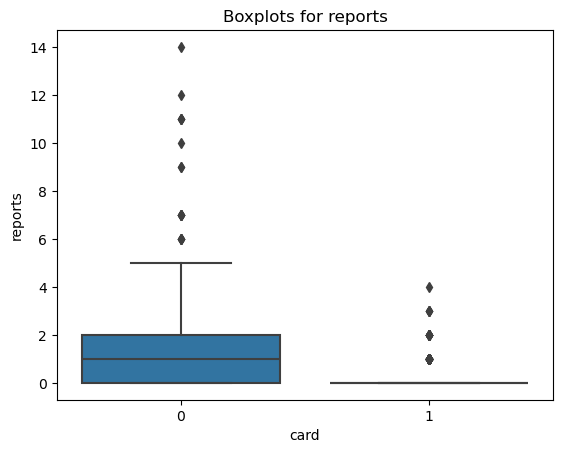

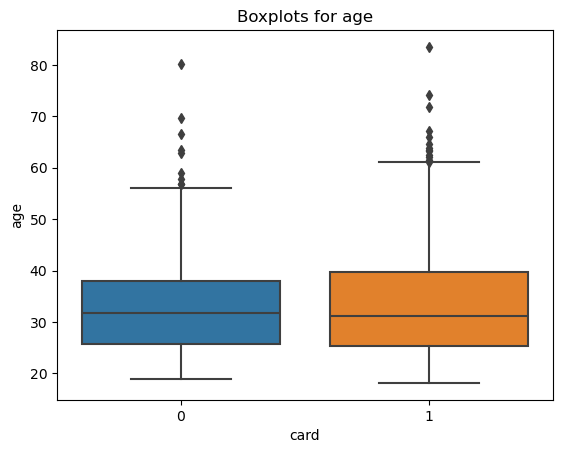

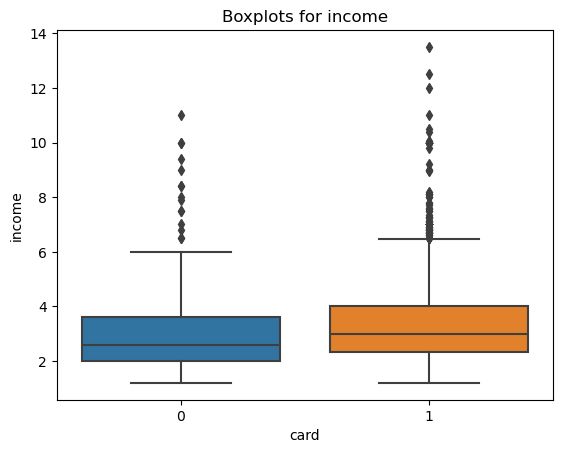

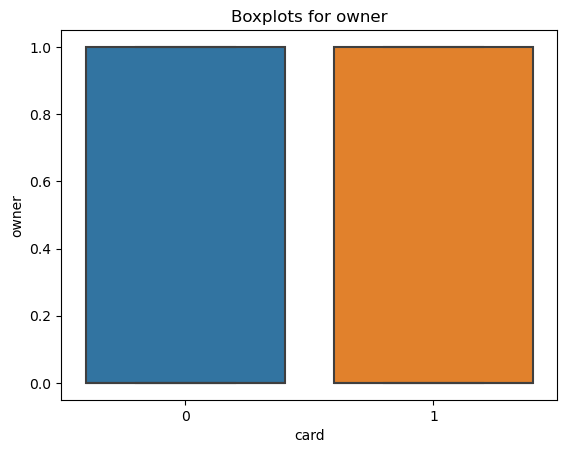

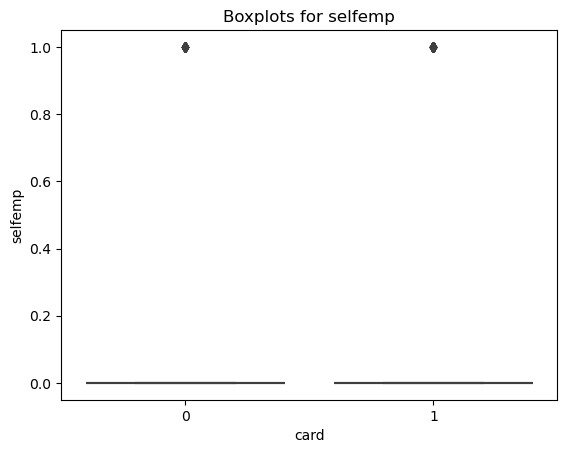

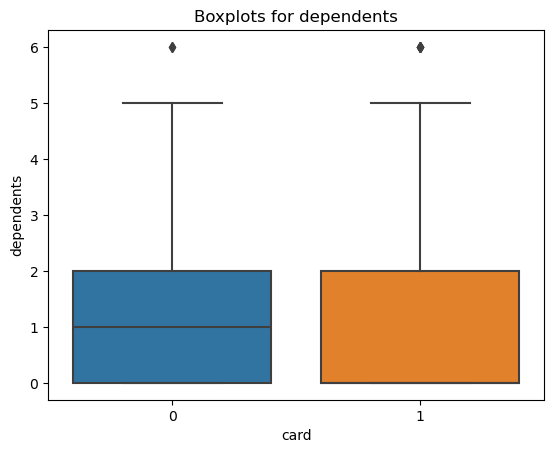

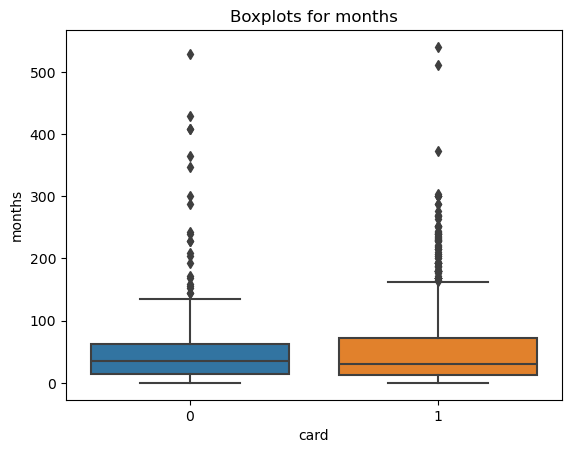

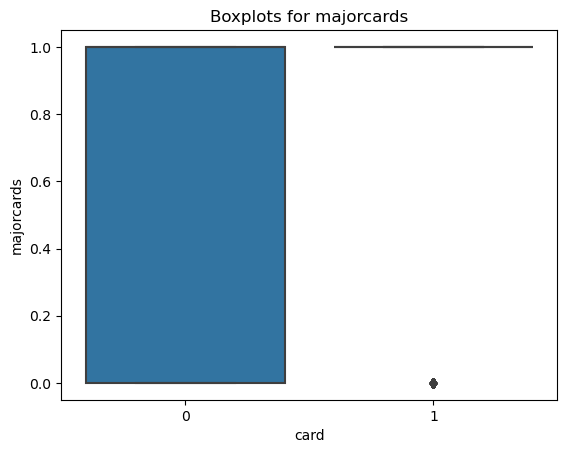

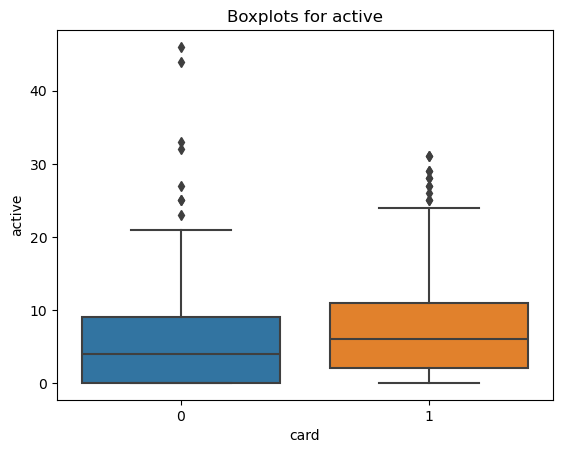

In [20]:
columns_to_compare = ['reports', 'age', 'income', 'owner', 'selfemp', 'dependents', 'months', 'majorcards', 'active']
for col in columns_to_compare:
    sns.boxplot(x=df['card'], y=df[col])
    plt.title(f'Boxplots for {col}')
    plt.show()

**Denied applications seem to have been declined mainly for:**

- having way **more reports**
- and/or having **lower income**
- and/or having **no other majorcards**
- and/or **less active accounts**

I'll do a statistical test to get a better point of view

Checking whether the difference in means is statistically significant between applications denied and accepted:
------------------------------------
Column: reports, p-value: 3.829814386114768e-61, 1 mean: 0.12903225806451613, 0 mean: 1.587837837837838
Column: income, p-value: 3.0907700526997686e-06, 1 mean: 3.4522407624633424, 0 mean: 3.0709077702702707
Column: owner, p-value: 8.02320281039493e-08, 1 mean: 0.47996089931573804, 0 mean: 0.30405405405405406
Column: selfemp, p-value: 0.048542228772949364, 1 mean: 0.06158357771260997, 0 mean: 0.0945945945945946
Column: majorcards, p-value: 9.14053500650036e-05, 1 mean: 0.8396871945259042, 0 mean: 0.7398648648648649
Column: active, p-value: 1.4138701299346246e-05, 1 mean: 7.269794721407624, 0 mean: 6.054054054054054


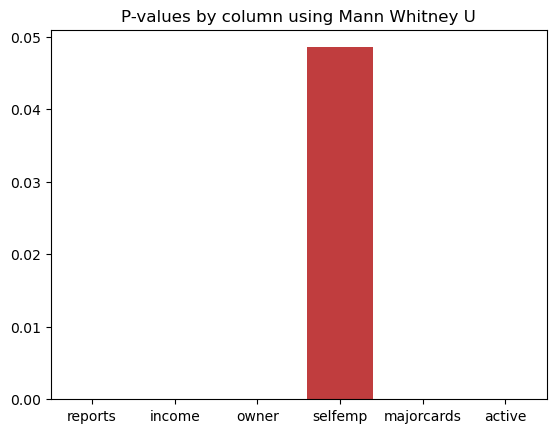

dict_values([3.829814386114768e-61, 3.0907700526997686e-06, 8.02320281039493e-08, 0.048542228772949364, 9.14053500650036e-05, 1.4138701299346246e-05])


In [21]:
accepted_card = df['card'] == 1
results = {}
print('Checking whether the difference in means is statistically significant between applications denied and accepted:')
print('------------------------------------')
for col in columns_to_compare:
    accepted = df.loc[accepted_card][col]
    denied = df.loc[~accepted_card][col]
    pvalue = stats.mannwhitneyu(accepted, denied)[1]
    if pvalue < 0.05:
        results[col] = pvalue
        print(f'Column: {col}, p-value: {pvalue}, 1 mean: {accepted.mean()}, 0 mean: {denied.mean()}')
#results_df = pd.DataFrame(results, index=results.keys)
#print(results_df.head())
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("P-values by column using Mann Whitney U")
plt.show()

The columns above differ significantly from denied to accepted applications.   
To finish the anlysis of the 0 class, I'll conduct a correlation test as well

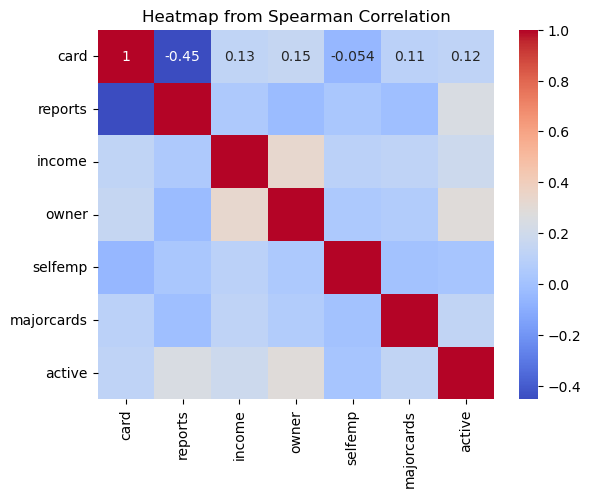

In [22]:
columns_to_correlate = ['card', 'reports', 'income', 'owner', 'selfemp', 'majorcards', 'active']
card_corr = df[columns_to_correlate].corr(method='spearman')
sns.heatmap(card_corr, annot=True, cmap='coolwarm')
plt.title('Heatmap from Spearman Correlation')
plt.show()

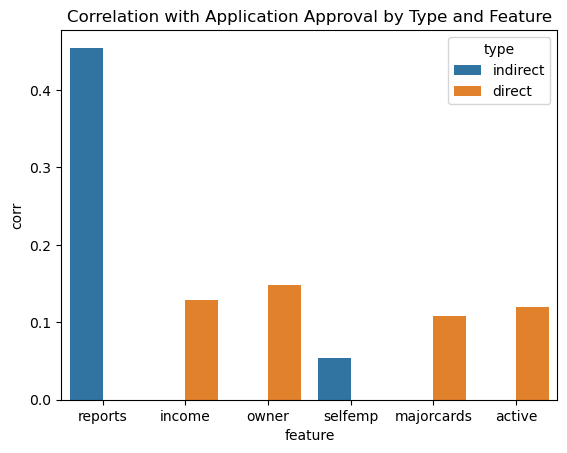

In [23]:
# Showing a barplot
card_corr = card_corr.iloc[0, 1:] # Getting just the correlations with card, excluding its own
indexes = card_corr.index
type_corr = ['direct' if corr > 0 else 'indirect' for corr in card_corr]
card_corr_df = pd.DataFrame({'corr': abs(card_corr), 'type': type_corr}, index=indexes)
sns.barplot(data = card_corr_df, x=indexes, y='corr', hue='type')
plt.xlabel('feature')
plt.title('Correlation with Application Approval by Type and Feature')
plt.show()

In summary, we conclude that **the main factor associated with having the applications denied is the number of major derrogatory reports.**

Now, I'll focus my analysis on the first predictive model: the **expenditure estimator.** Steps will be as follows:  

1. Slice df so it contains only rows where expenses > 0
2. Normalize/Scale variables to be able to have more statistic tests and regression models available
3. Conduct bivariate and multivariate analysis to understand what possibly infleunces expenditure
4. Start pre-processing, selecting a model, training, testing, evaluating, etc.

In [24]:
# Creating df_expenses
df_expenditure = df.loc[df['expenditure']>0].copy()
df_expenditure.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,yearly_expenditure,expected_share,target
0,1,0,37.66667,4.5200,0.033270,124.983300,1,0,3,54,1,12,0.149980,0.033181,2
1,1,0,33.25000,2.4200,0.005217,9.854167,0,0,3,34,1,13,0.011825,0.004886,2
2,1,0,33.66667,4.5000,0.004156,15.000000,1,0,4,58,1,5,0.018000,0.004000,2
3,1,0,30.50000,2.5400,0.065214,137.869200,0,0,0,25,1,7,0.165443,0.065135,2
4,1,0,32.16667,9.7867,0.067051,546.503300,1,0,2,64,1,5,0.655804,0.067010,2


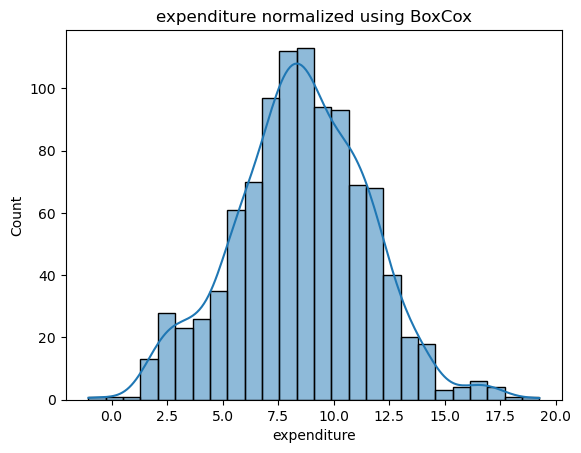

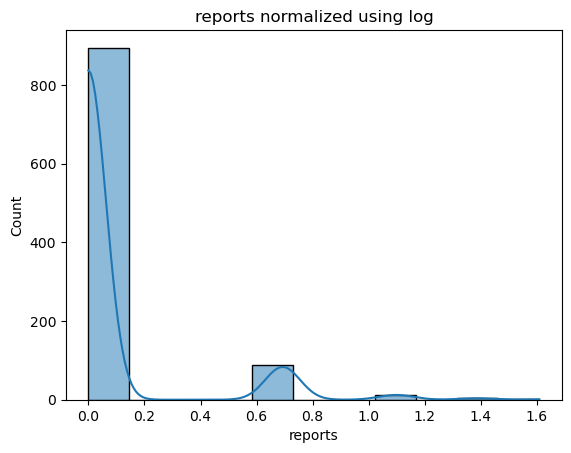

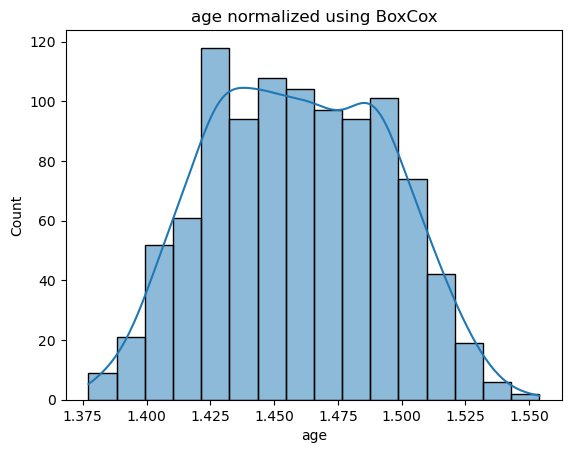

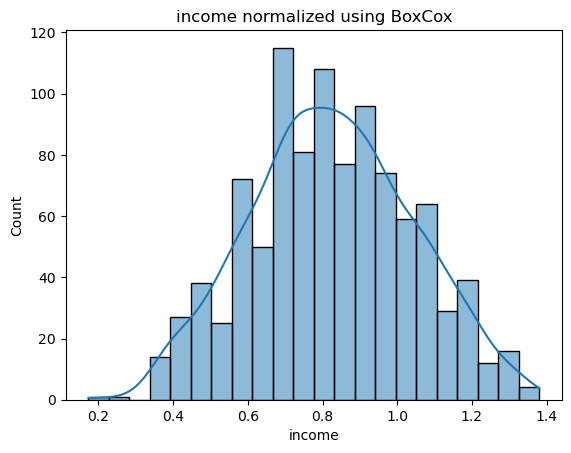

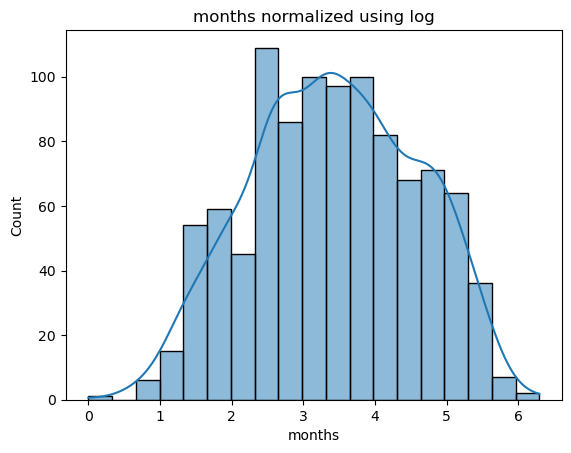

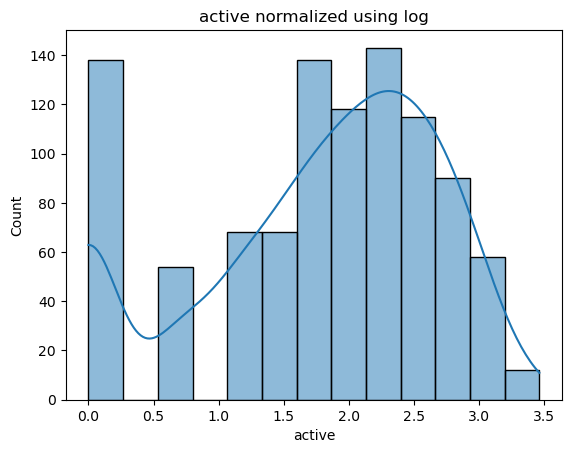

In [25]:
continuous_features = ['expenditure', 'reports', 'age', 'income', 'months', 'active']
for feat in continuous_features:
    if (df_expenditure[feat] > 0).all(): 
        # Normalizing using boxcox
        df_expenditure[feat] = stats.boxcox(df_expenditure[feat])[0]
        sns.histplot(df_expenditure[feat], kde=True)
        plt.title(f'{feat} normalized using BoxCox')
        plt.show()
    else:
        # Normalizing using log
        df_expenditure[feat] = np.log(df_expenditure[feat]+1)
        sns.histplot(df_expenditure[feat], kde=True)
        plt.title(f'{feat} normalized using log')
        plt.show()

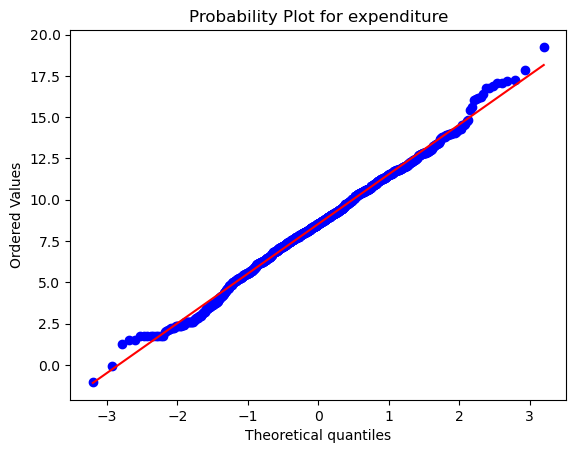

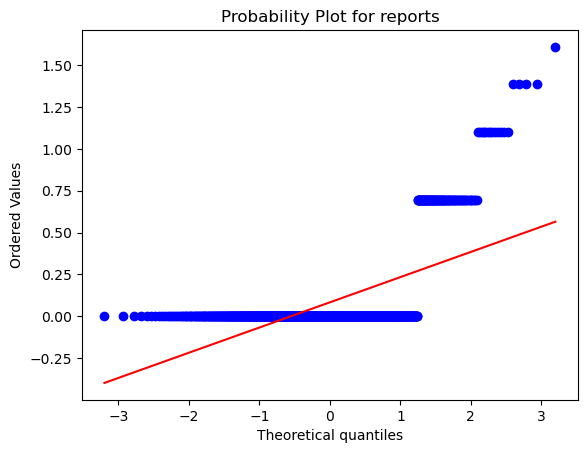

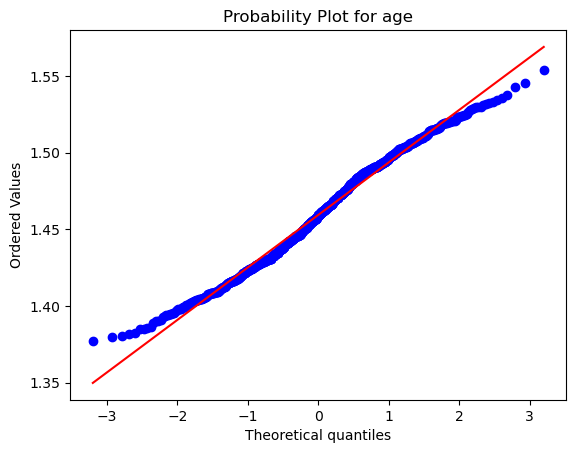

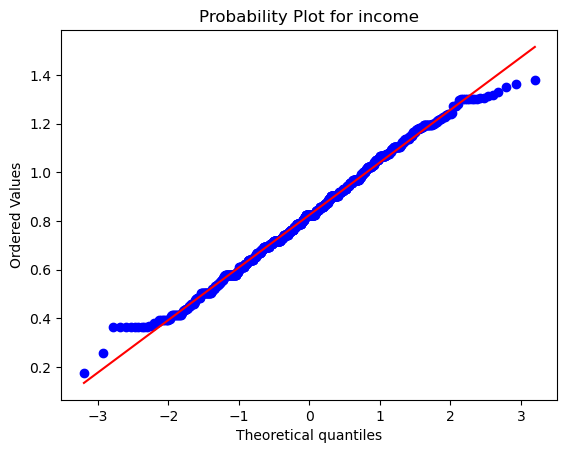

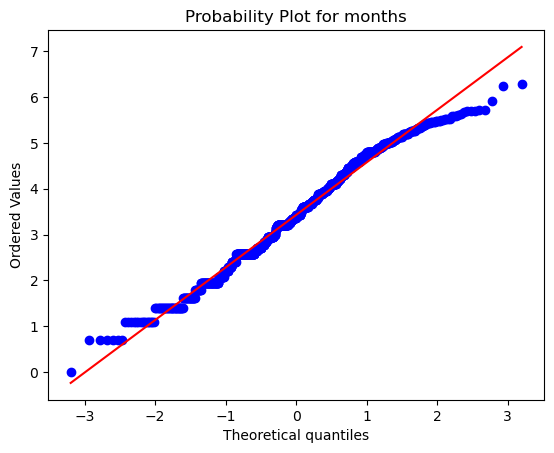

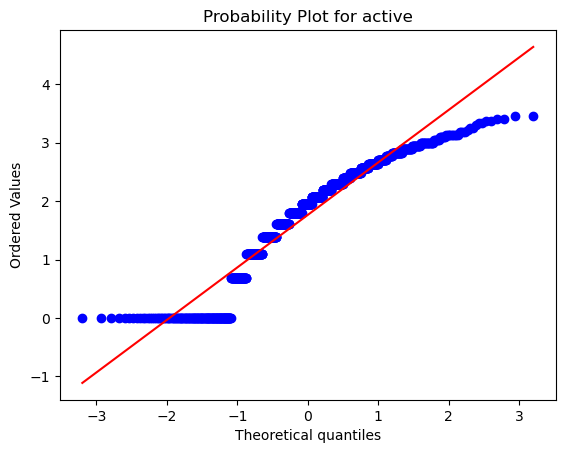

In [28]:
# Verifying transformations
for col in continuous_features:
    stats.probplot(df_expenditure[col], plot=plt)
    plt.title(f'Probability Plot for {col}')
    plt.show()

The columns became approximately normal. Now I will check the correlation between them

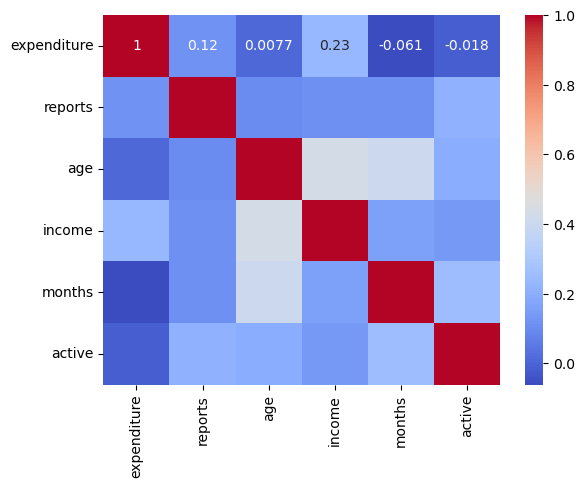

In [45]:
exp_corr = df_expenditure[continuous_features].corr()
sns.heatmap(exp_corr, annot=True, cmap='coolwarm')
plt.show()

There is but a week correlation with income. But it doesn't seem to be very correlated with the other features

In [34]:
# Checking p-value
stats.pearsonr(df_expenditure['expenditure'], df_expenditure['income'])

PearsonRResult(statistic=0.23400038914956295, pvalue=6.271230255260611e-14)

Before I finish, I will do 2 more kind of plots:
1. Scatter plots w/ regression lines between expenditure and continuous features
2. Boxplot between expenditures and discrete/ordinal features

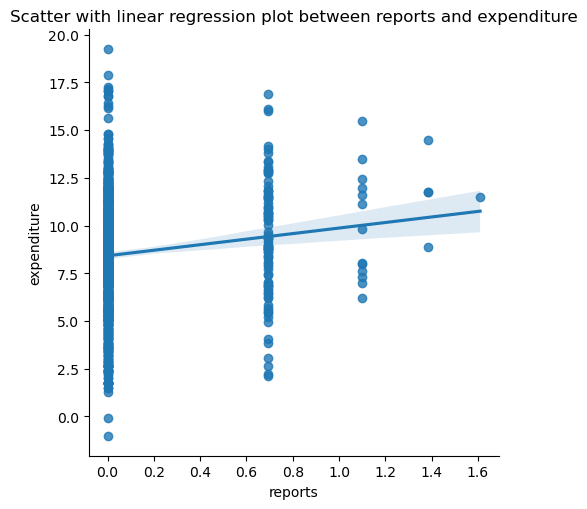

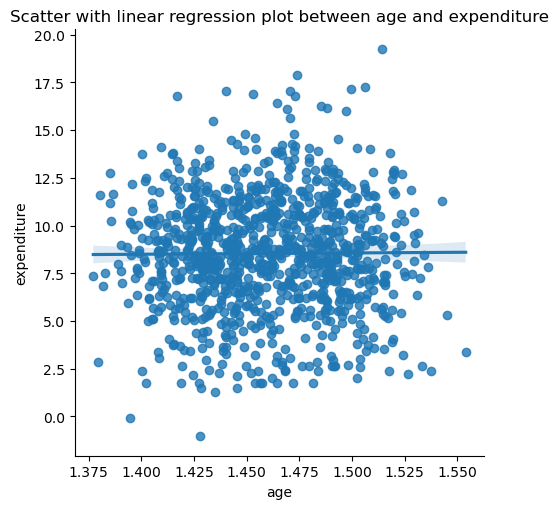

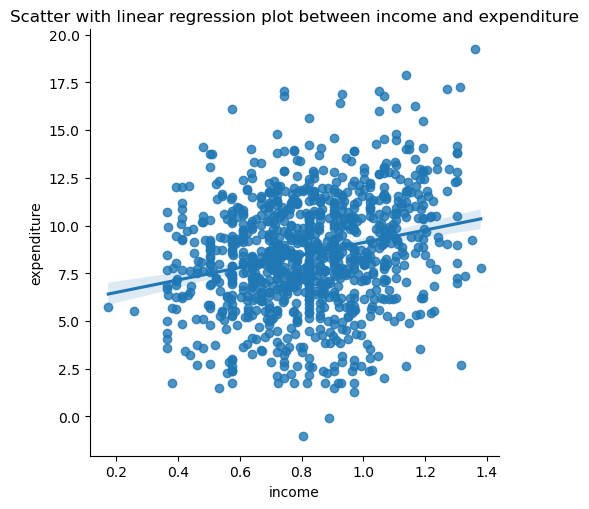

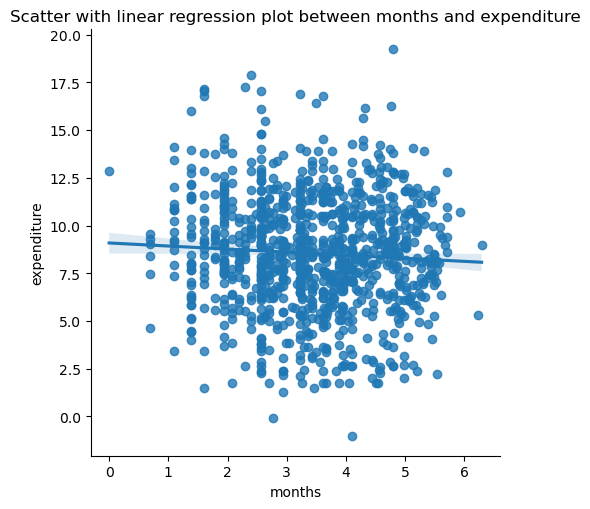

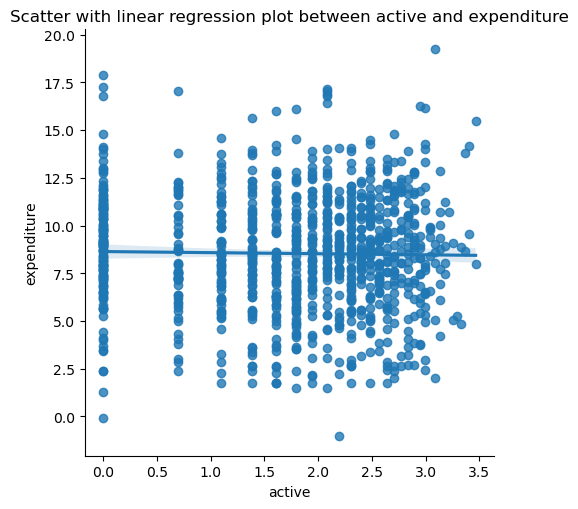

In [42]:
# Verifying continuos features
for col in continuous_features[1:]:
    sns.lmplot(data=df_expenditure, x=col, y='expenditure')
    plt.title(f'Scatter with linear regression plot between {col} and expenditure')
    plt.show()


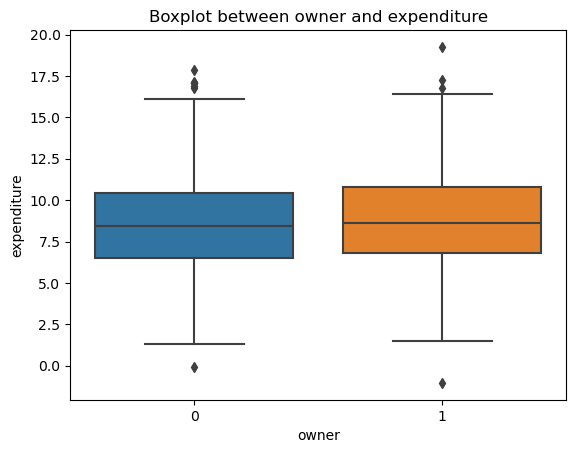

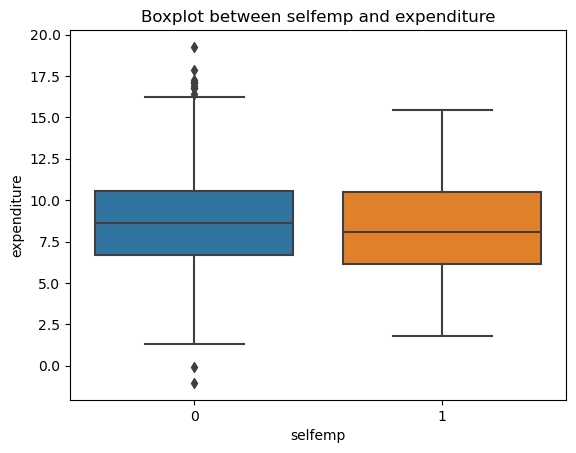

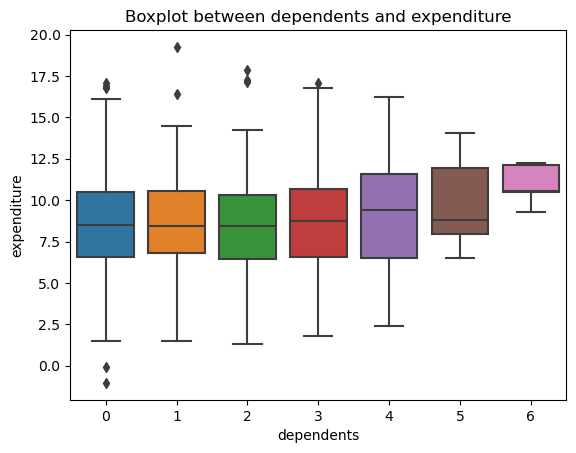

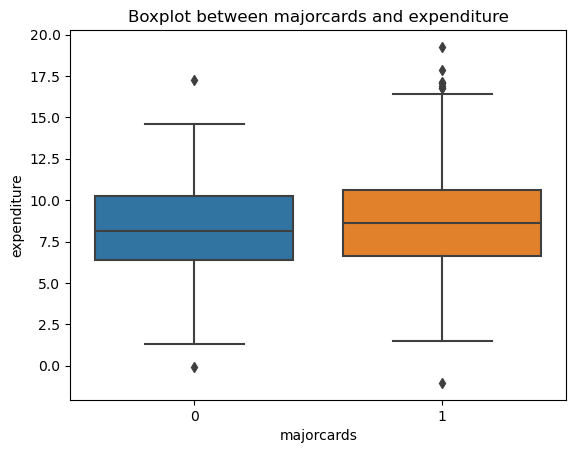

In [48]:
# Discrete / Ordinal columns
for col in ['owner', 'selfemp', 'dependents', 'majorcards']:
    sns.boxplot(data=df_expenditure, x=col, y='expenditure')
    plt.title(f"Boxplot between {col} and expenditure")
    plt.show()

After these initial analysis to understand how to predict expenditure, I decided to select a few features that seemed mostly associated with it. They are:

- income 
- reports
- dependents

Although it may sound simple, I'm willing to start with a simpler model and, if needed, do more feature engineering to enhance it.